# Assignment 1

Jonathan McEntee - September 9th 2018

Things that need to be done:
 - Find two "interesting" datasets. Aka, datasets that don't train exactly the same accuracy
 - Explain the cars dataset classification problem and why you feel its interesting
 - Write an introduction to the second dataset (digits?)
 - Fix the cross_validation v training graphs
 - Measure the time it takes to run each algorithm, also under different circumstances
 - Perform analysis on datasets/algorithms including:
  - how fast each model ran
  - which algorithm performed best
  - how do you define best?
  - analysis of why you chose different hyperparameter options

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import graphviz

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit, validation_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC

## Abalone Data Set

In [2]:
abalone_data = pd.read_csv('abalone.csv')
abalone_data.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [6]:
abalone_data = abalone_data[abalone_data.sex != 'I']
abalone_data.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20


In [ ]:
def convert_to_age_categories(num_rings):
    if num_rings < 9:
        return "Young"
    elif num_rings < 11:
        return "Middle-Aged"
    else:
        return "Old"
    
age_categories = abalone_data.rings.apply(convert_to_age_categories)
abalone_data = abalone_data.assign(age_category = age_categories)
abalone_data.head()

/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/statsmo

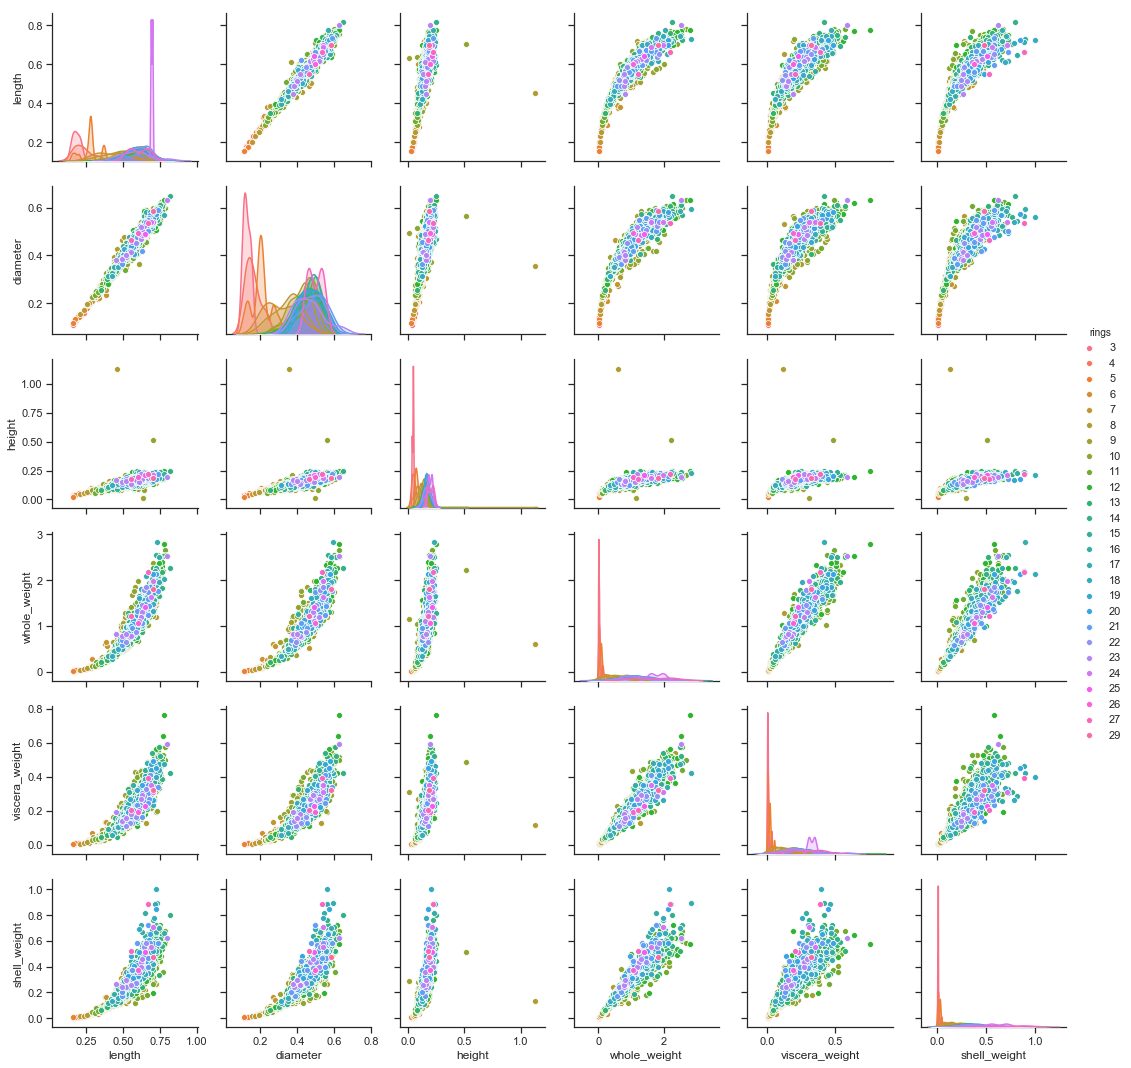

In [7]:
sns.set(style='ticks')
data_to_pairplot = abalone_data.drop(['shucked_weight'], axis=1)
sns.pairplot(data_to_pairplot, hue='rings', vars=['length', 'diameter', 'height',
                                                  'whole_weight', 'viscera_weight',
                                                  'shell_weight'])

Lets make a training and a test set

In [ ]:
# abalone_data = abalone_data.assign(**pd.get_dummies(abalone_data.sex)).drop(['sex'], axis=1)

In [8]:
y = abalone_data['sex']
X = abalone_data.drop(['sex'], axis=1)

## Blood Transfusion Data Set

In [ ]:
blood_data = pd.read_csv('transfusions.csv')
blood_data["donated_blood"] = blood_data.donated_blood.apply(lambda x : 'Yes' if x is 1 else 'No')
blood_data.head()

In [ ]:
sns.set(style='ticks')
sns.pairplot(blood_data, hue='donated_blood', vars=['frequency', 'time'])

In [ ]:
y = blood_data["donated_blood"]
X = blood_data.drop(["donated_blood"], axis=1)

## Car Data Set

In [ ]:
car_data = pd.read_csv('car.csv')
car_data['car_rating'] = car_data.car_rating.apply(lambda x: 'acc' if x != 'unacc' else 'unacc')
car_data.head()

In [ ]:
car_data.car_rating.value_counts()

In [ ]:
car_data = pd.get_dummies(car_data, columns=['buying_price', 'maintenance', 'num_doors', 'persons', 'luggage_boot', 'safety'])

In [ ]:
y = car_data.car_rating
X = car_data.drop(['car_rating'], axis=1)

## Create Test and Training Sets

In [9]:
y_train, y_test = train_test_split(y, test_size=0.2, stratify=y, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.2, stratify=y, random_state=42)

## Functions

In [12]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding tfdrain/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    taken from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_validation_curve(estimator, title, X, y, ylim=None, cv=None,
                          n_jobs=1, param_name=None, alternative_x_axis=None,
                          param_range=np.linspace(1, 100, 10)):
    
    x_axis = alternative_x_axis if alternative_x_axis is not None else param_range
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Parameter Setting")
    plt.ylabel("Score")
    train_scores, test_scores = validation_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, param_name=param_name, param_range=param_range)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(param_range, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(param_range, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


## Using a Decision Tree Classifier

First we'll find the best parameters with a grid search

In [10]:
parameters = {
    'max_depth' : list(range(1, 30, 2)),
    'min_samples_split' : list(range(20, 1000, 10))
}

decision_tree = DecisionTreeClassifier()
clf = GridSearchCV(decision_tree, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': 7, 'min_samples_split': 150}

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

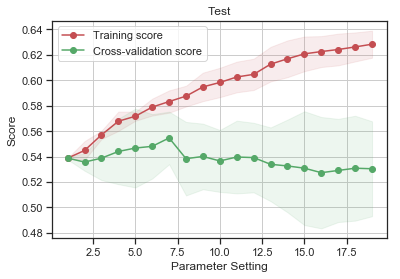

In [15]:
# built in validation curve
clf = DecisionTreeClassifier(min_samples_split=210)
plot_validation_curve(estimator=clf, title="Test", X=X_train, y=y_train, param_name='max_depth',
                      param_range=range(1, 20), cv=10)

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

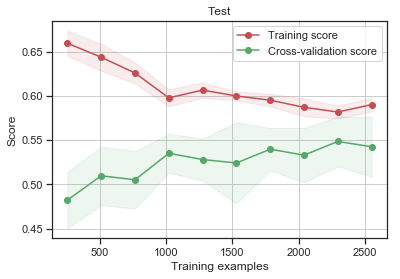

In [16]:
# the built in learning curve
clf = DecisionTreeClassifier(max_depth=7, min_samples_split=150)
plot_learning_curve(estimator=clf, title="Test", X=X, y=y, cv=10)

In [ ]:
dot_data = export_graphviz(clf, out_file=None,  
                         feature_names=car_data.drop(['car_rating'], axis=1).columns,
                         class_names = ['Non-Acceptable', 'Acceptable'],
                         filled=True, rounded=True,  
                         special_characters=True)  

graphviz.Source(dot_data)  

## Using K Nearest Neighbors

In [17]:
parameters = {
    'n_neighbors' : list(range(1, 30)),
    'weights' : ['uniform', 'distance'],
    "p" : [1, 2]
}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'n_neighbors': 4, 'p': 2, 'weights': 'distance'}

A grid search reveals the optimum hyperparameters to be n_neighbors = 12, p = 1, and weights = 'distance'

On the car dataset, where all the features are binary classifiers, this algorithm will be looking for similarity in a way that weights all features exactly the same. Which may effect its accuracy

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

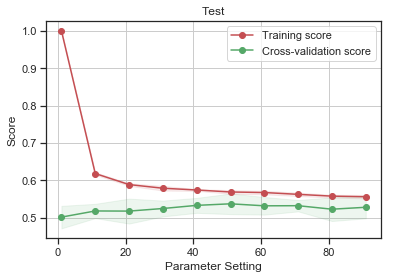

In [21]:
clf = KNeighborsClassifier(p=1)
plot_validation_curve(estimator=clf, title="Test", X=X_train, y=y_train, param_name='n_neighbors',
                      param_range=range(1, 100, 10), cv=10)

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

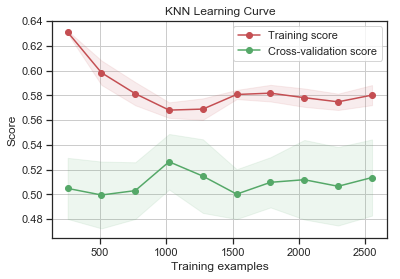

In [18]:
# the built in learning curve
clf = KNeighborsClassifier(p=1, n_neighbors=40)
plot_learning_curve(estimator=clf, title="KNN Learning Curve", X=X, y=y, cv=10)

## Using AdaBoost

In [19]:
parameters = {
    'n_estimators' : list(range(20, 80)),
    'learning_rate' : [10**x for x in range(-1, 2)],
}

ada_booster = AdaBoostClassifier()
clf = GridSearchCV(ada_booster, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'learning_rate': 1, 'n_estimators': 26}

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

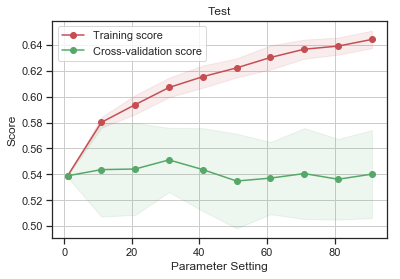

In [21]:
clf = AdaBoostClassifier(learning_rate=1)
plot_validation_curve(estimator=clf, title="Test", X=X_train, y=y_train, param_name='n_estimators',
                      param_range=range(1, 100, 10), cv=10)

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

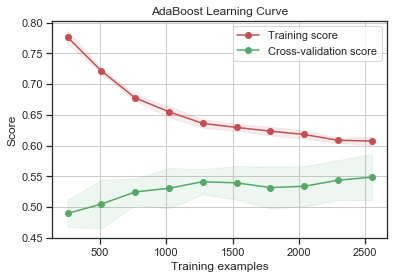

In [20]:
# the built in learning curve
clf = AdaBoostClassifier(learning_rate=1, n_estimators=40)
plot_learning_curve(estimator=clf, title="AdaBoost Learning Curve", X=X, y=y, cv=10)

## Using a Neural Net

In [22]:
parameters = {
    'hidden_layer_sizes' : [tuple([x] * n) for x in range(10,100,10) for n in range(1,5)],
    'max_iter' : range(200, 500, 100)
}

# 'max_iter' : range(200, 500, 50),

mlp = MLPClassifier()
clf = GridSearchCV(mlp, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'hidden_layer_sizes': (40, 40, 40), 'max_iter': 300}

Best hidden layer size = 3 rows of 50 (50, 50, 50)
for the cars dataset = (70, 70, 70)

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

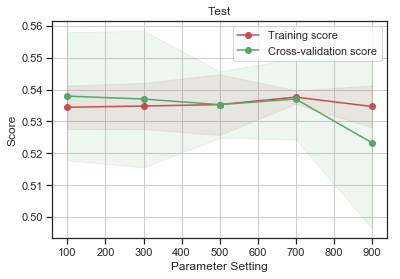

In [24]:
clf = MLPClassifier(hidden_layer_sizes=(40, 40, 40))
plot_validation_curve(estimator=clf, title="Test", X=X_train, y=y_train, param_name='max_iter',
                      param_range=range(100, 1000, 200), cv=10)

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

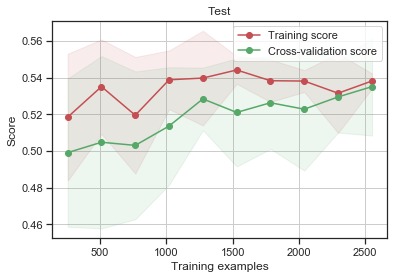

In [25]:
# the built in learning curve
clf = MLPClassifier(hidden_layer_sizes=(40, 40, 40), max_iter=200)
plot_learning_curve(estimator=clf,
                    title="Test", X=X, y=y, cv=10)

## Using a Support Vector Machine

In [ ]:
parameters = [{
    'C' : [1, 10, 100, 1000],
    'kernel' : ['poly'],
    'degree' : range(1,10)
},
{
    'C' : [1, 10, 100, 1000],
    'kernel' : ['rbf'],
    'gamma': [1e-3, 1e-4]
},
{
    'C' : [1, 10, 100, 1000],
    'kernel' : ['linear']
}
]

lsvc = SVC()
clf = GridSearchCV(lsvc, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

In [ ]:
poly = SVC(C=1000, kernel='poly', degree=2)
rbf = SVC(C=1000, gamma=0.001)
linear = LinearSVC(C=10)

for model in (poly, rbf, linear):
    model.fit(X=X_train, y=y_train)

In [ ]:
svm_scores = pd.DataFrame({
    "kernel" : ['polynomial', 'linear', 'rbf'],
    "training score" : [poly.score(X_train, y_train),
                        linear.score(X_train, y_train),
                        rbf.score(X_train, y_train)],
    "cross validation score" : [cross_val_score(poly, X=X_train, y=y_train, cv=10).mean(),
                                cross_val_score(linear, X=X_train, y=y_train, cv=10).mean(),
                                cross_val_score(rbf, X=X_train, y=y_train, cv=10).mean()]
})

In [ ]:
# the built in learning curve
clf = SVC(kernel='poly', degree=3, C=1000)
plot_learning_curve(estimator=clf, title="Test", X=X, y=y, cv=StratifiedShuffleSplit())

In [ ]:
clf = LinearSVC(C=10)
plot_learning_curve(estimator=clf, title="Test", X=X, y=y, cv=10)

In [ ]:
clf = SVC(kernel='poly', degree=3, C=1000)
plot_learning_curve(estimator=clf, title="Test", X=X, y=y, cv=10)